In [30]:
# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
import holodeck.gravwaves
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
plt.rcParams.update({'grid.alpha': 0.5})
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode

log = holo.log
log.setLevel(logging.INFO)

In [33]:
def plot_bin_pop(pop):
    mt, mr = utils.mtmr_from_m1m2(pop.mass)
    redz = cosmo.a_to_z(pop.scafa)
    data = [mt/MSOL, mr, pop.sepa/PC, 1+redz]
    data = [np.log10(dd) for dd in data]
    reflect = [None, [None, 0], None, [0, None]]
    labels = [r'M/M_\odot', 'q', r'a/\mathrm{{pc}}', '1+z']
    labels = [r'${{\log_{{10}}}} \left({}\right)$'.format(ll) for ll in labels]

    if pop.eccen is not None:
        data.append(pop.eccen)
        reflect.append([0.0, 1.0])
        labels.append('e')

    kde = kale.KDE(data, reflect=reflect)
    corner = kale.Corner(kde, labels=labels, figsize=[8, 8])
    corner.plot_data(kde)
    return corner

def compare_bin_pops(pops, labels=None, var='mass', colors=None, lws=None, 
                     density=True, hist=False, confidence=False):
    assert isinstance(pops, list), '`pops` must be a list of binary populations'
    assert var in ['mass','mrat','sepa','redz'], "`var` must be 'mass','mrat','sepa', or 'redz'."
    if (labels is not None):
        if (len(labels) != len(pops)) and (not isinstance(labels,str)):
            print("Warning: `labels` must be a str or a list of length len(pops). Setting to None.")
            labels = None
   
    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    
    if (colors is not None) and (lws is None):
        lws = [1.0]*len(pops)

    if (var == 'mass') or (var == 'mrat'):
        for i,pop in enumerate(pops):
            mt, mr = utils.mtmr_from_m1m2(pop.mass)
            data = np.log10(mt/MSOL) if var=='mass' else mr
            #print(data.min(),data.max())
            xlab = r'$\log_{10}(M_{tot})$' if var=='mass' else r'$q$'
            ax.set(xlabel=xlab)
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, label=labels[i])
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=labels[i], color=colors[i], lw=lws[i])

    elif var == 'sepa':
        for i,pop in enumerate(pops):
            data = np.log10(pop.sepa/PC)
            #print(data.min(),data.max())
            ax.set(xlabel=r'$\log_{10}(a) [pc]$')
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, label=labels[i])
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=labels[i], color=colors[i], lw=lws[i])

    else:
        for i,pop in enumerate(pops):
            redz = cosmo.a_to_z(pop.scafa)
            data = 1+redz
            #print(data.min(),data.max())
            ax.set(xlabel=r'$\log_{10}(1+z)$')
            if colors is None:
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, label=labels[i])
            else: 
                kale.dist1d(data, density=density, hist=hist, confidence=confidence, 
                            label=labels[i], color=colors[i], lw=lws[i])

def compare_bhmfs(dpops, colors=None, lws=None, labels=None):
    
    assert isinstance(dpops, list), '`dpops` must be a list of binary populations'

    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    ax.set(yscale='log')
    
    if (colors is not None) and (lws is None):
        lws = [1.0]*len(dpops)

    for i,dp in enumerate(dpops):
        mt, mr = utils.mtmr_from_m1m2(dp.pop.mass)
        data = np.log10(mt/MSOL)
        #mbinsize = 0.5
        #mbins = np.arange(4.75, 11.25, mbinsize)
        mhist, mbin_edges = np.histogram(data, range=(5.25,11.25), bins=12) #bins=mbins)
        mbinsize = mbin_edges[1]-mbin_edges[0]
        mbins = mbin_edges[:-1]+mbinsize
        
        xlab = r'$\log_{10}(M_{tot})$' 
        ax.set(xlabel=xlab)
        ax.set(ylabel=r'BHMF [$(\log_{10} M)^{-1} Mpc^{-3}$]')
        #print(mhist.size, mbin_edges.size) #, mbins.size)
        #print(mbin_edges)
        #print(mhist)
        box_vol_mpc = dp.evo._sample_volume / (1.0e6*PC)**3
        plt.plot(mbins, mhist/mbinsize/box_vol_mpc, color=colors[i], lw=lws[i], label=labels[i])

def compare_gsmfs(dpops, colors=None, lws=None, labels=None):
    
    assert isinstance(dpops, list), '`dpops` must be a list of binary populations'

    fig, ax = plt.subplots(figsize=[10, 5])
    ax.set(ylabel='Probability Density')
    ax.grid(alpha=0.01)
    ax.set(yscale='log')
    
    if (colors is not None) and (lws is None):
        lws = [1.0]*len(dpops)

    for i,dp in enumerate(dpops):
        #mt, mr = utils.mtmr_from_m1m2(dp.pop.mass)
        data = np.log10(dp.pop.mbulge/MSOL)
        #mbinsize = 0.5
        #mbins = np.arange(4.75, 11.25, mbinsize)
        mhist, mbin_edges = np.histogram(data, range=(7.25,14.25), bins=20) #bins=mbins)
        mbinsize = mbin_edges[1]-mbin_edges[0]
        mbins = mbin_edges[:-1]+mbinsize
        
        xlab = r'$\log_{10}(M_{*})$' 
        ax.set(xlabel=xlab)
        ax.set(ylabel=r'GSMF [$(\log_{10} M)^{-1} Mpc^{-3}$]')
        #print(mhist.size, mbin_edges.size) #, mbins.size)
        #print(mbin_edges)
        #print(mhist)
        box_vol_mpc = dp.evo._sample_volume / (1.0e6*PC)**3
        plt.plot(mbins, mhist/mbinsize/box_vol_mpc, color=colors[i], lw=lws[i], label=labels[i])


            
def plot_mbh_scaling_relations(pop, fname=None, color='r', compare_pops=None, ncols=1, nrows=1,
                               xlim=None, ylim=None):
    units = r"$[\log_{10}(M/M_\odot)]$"

    if compare_pops == None:
        fig, axes = plt.subplots(figsize=[12, 6])
        pops = [pop]
    else:
        fig, axes = plt.subplots(figsize=[12,5], ncols=ncols, nrows=nrows)
        pops = [pop] + compare_pops
        if len(pops) > ncols*nrows:
            raise ValueError(f"len(pops)>ncols*nrows. ({len(pops)} > {ncols}*{nrows}).")

    i = 0
    for idx, ax in np.ndenumerate(axes):
        if i > len(pops): break

        print(f"idx: {idx}, i: {i}")
        ax.set(xlabel=f'Stellar Mass {units}', ylabel=f'BH Mass {units}')
        if xlim is not None: ax.set(xlim=xlim)
        if ylim is not None: ax.set(ylim=ylim)

        #   ====    Plot McConnell+Ma-2013 Data    ====
        handles = []
        names = []
        if fname is not None:
            hh = _draw_MM2013_data(ax, fname)
            handles.append(hh)
            names.append('McConnell+Ma')

        #   ====    Plot MBH Merger Data    ====
        hh, nn = _draw_pop_masses(ax, pops[i], color, nplot=1e6)
        handles = handles + hh
        names = names + nn
        ax.legend(handles, names)
        
        i += 1

    return fig

def _draw_MM2013_data(ax):
    data = holo.observations.load_mcconnell_ma_2013()
    data = {kk: data[kk] if kk == 'name' else np.log10(data[kk]) for kk in data.keys()}
    key = 'mbulge'
    mass = data['mass']
    yy = mass[:, 1]
    yerr = np.array([yy - mass[:, 0], mass[:, 2] - yy])
    vals = data[key]
    if np.ndim(vals) == 1:
        xx = vals
        xerr = None
    elif vals.shape[1] == 2:
        xx = vals[:, 0]
        xerr = vals[:, 1]
    elif vals.shape[1] == 3:
        xx = vals[:, 1]
        xerr = np.array([xx-vals[:, 0], vals[:, 2]-xx])
    else:
        raise ValueError()

    idx = (xx > 0.0) & (yy > 0.0)
    if xerr is not None:
        xerr = xerr[:, idx]
    ax.errorbar(xx[idx], yy[idx], xerr=xerr, yerr=yerr[:, idx], fmt='none', zorder=10)
    handle = ax.scatter(xx[idx], yy[idx], zorder=10)
    ax.set(ylabel='MBH Mass', xlabel=key)

    return handle

def _draw_pop_masses(ax, pop, color='r', nplot=3e3):
    print(pop.mbulge.shape, pop.mass.shape)
    #xx = pop.mbulge.flatten() / MSOL
    xx = pop.mbulge[:,:2].flatten() / MSOL
    yy_list = [pop.mass]
    names = ['new']
    if hasattr(pop, '_mass'):
        yy_list.append(pop._mass)
        names.append('old')

    colors = [color, '0.5']
    handles = []
    if xx.size > nplot:
        cut = np.random.choice(xx.size, int(nplot), replace=False)
        print("Plotting {:.1e}/{:.1e} data-points".format(nplot, xx.size))
    else:
        cut = slice(None)

    for ii, yy in enumerate(yy_list):
        yy = yy.flatten() / MSOL
        data = np.log10([xx[cut], yy[cut]])
        kale.plot.dist2d(
            data, ax=ax, color=colors[ii], hist=False, contour=True,
            median=True, mask_dense=True,
        )
        hh, = plt.plot([], [], color=colors[ii])
        handles.append(hh)

    return handles, names

def plot_evo(evo, freqs=None, sepa=None, ax=None, label=None, color=None, **kwargs):
    if (freqs is None) and (sepa is None):
        err = "Either `freqs` or `sepa` must be provided!"
        log.exception(err)
        raise ValueError(err)

    if freqs is not None:
        data = evo.at('fobs', freqs)
        xx = freqs * YR
        xlabel = 'GW Frequency [1/yr]'
    else:
        data = evo.at('sepa', sepa)
        xx = sepa / PC
        xlabel = 'Binary Separation [pc]'

    if ax is None:
        fig, ax = plot.figax(xlabel=xlabel)
    else:
        fig = ax.get_figure()

    def _draw_vals_conf(ax, xx, vals, color=color, label=label):
        if color is None:
            color = ax._get_lines.get_next_color()
        if label is not None:
            ax.set_ylabel(label, color=color)
            ax.tick_params(axis='y', which='both', colors=color)
        # vals = np.percentile(vals, [25, 50, 75], axis=0) / units
        vals = utils.quantiles(vals, [0.25, 0.50, 0.75], axis=0).T
        h1 = ax.fill_between(xx, vals[0], vals[-1], alpha=0.2, color=color)
        h2, = ax.plot(xx, vals[1], alpha=0.5, lw=2.0, color=color)
        return (h1, h2)

    # handles = []
    # labels = []

    name = 'Hardening Time [yr]'
    vals = np.fabs(data['sepa'] / data['dadt']) / YR
    _draw_vals_conf(ax, xx, vals, label=name)
    # handles.append(hh)
    # labels.append(name)

    # name = 'eccen'
    # tw = ax.twinx()
    # hh, nn = _draw_vals_conf(tw, freqs*YR, name, 'green')
    # if hh is not None:
    #     handles.append(hh)
    #     labels.append(nn)

    # ax.legend(handles, labels)
    return ax

In [3]:
class Discrete:
    
    def __init__(self, freqs, freqs_edges, fname=None, lbl=None, fixed_sepa=None, 
                 tau=2.0*YR, nreals=500, mod_mmbulge=False, rescale_mbulge=False):
        self.freqs = freqs
        self.freqs_edges = freqs_edges
        self.lbl = lbl
        self.fname = fname
        self.fixed_sepa = fixed_sepa
        self.tau = tau
        self.nreals = nreals
        self.mod_mmbulge = mod_mmbulge
        
        print(f"\nCreating Discrete_Pop class instance '{self.lbl}' with tau={self.tau}, fixed_sepa={self.fixed_sepa}")
        print(f" fname={self.fname}")
        self.pop = holo.population.Pop_Illustris(fname=self.fname, fixed_sepa=self.fixed_sepa)

        # apply modifiers if requested
        if self.mod_mmbulge == True:
            self.mmbulge = holo.relations.MMBulge_KH2013()
            self.mod_KH2013 = holo.population.PM_Mass_Reset(self.mmbulge, scatter=True, 
                                                            rescale_mbulge=rescale_mbulge)
            self.pop.modify(self.mod_KH2013)

        # create a fixed-total-time hardening mechanism
        print(f"modeling fixed-total-time hardening...")
        self.fixed = holo.hardening.Fixed_Time_2PL.from_pop(self.pop, self.tau)

        # Create an evolution instance using population and hardening mechanism
        print(f"creating evolution instance and evolving it...")
        self.evo = holo.evolution.Evolution(self.pop, self.fixed)
        # evolve binary population
        self.evo.evolve()
        print("vol:",self.evo._sample_volume)

        ## create GWB
        self.gwb = holo.gravwaves.GW_Discrete(self.evo, self.freqs, nreals=self.nreals)
        self.gwb.emit()

    def get_amplitudes_at_freqs(self, select_freqs=None):
        if (select_freqs is not None):
            print("sorry this function sucks, you cannot select freqs yet. choosing 1/yr, 1/3yr, 1/10yr.")
        
        # ---- find frequency bins closest to 1/yr, 1/(3yr), 1/(10yr)
        self.idx_ayr = np.where(np.abs(self.freqs-1/YR)==np.abs(self.freqs-1/YR).min())[0]
        self.idx_a3yr = np.where(np.abs(self.freqs-1/(3*YR))==np.abs(self.freqs-1/(3*YR)).min())[0]
        self.idx_a10yr = np.where(np.abs(self.freqs-1/(10*YR))==np.abs(self.freqs-1/(10*YR)).min())[0]
        print(self.idx_ayr,self.idx_a3yr,self.idx_a10yr)

        self.ayr = self.gwb.back[self.idx_ayr,:].flatten()
        self.a3yr = self.gwb.back[self.idx_a3yr,:].flatten()
        self.a10yr = self.gwb.back[self.idx_a10yr,:].flatten()




Create an Illustris-Based Population, and a simple binary-evolution model

In [4]:
# ---- Set the fixed binary lifetime
#tau = 2.0 * GYR 
tau = 1.0 * GYR 
####################################

fixed_sepa = 1.0e4 * PC

# construct sampling frequencies
freqs = holo.utils.nyquist_freqs(dur=20.0*YR, cad=0.25*YR, lgspace=True)
freqs_edges = holo.utils.nyquist_freqs_edges(dur=20.0*YR, cad=0.25*YR, lgspace=True)
### freqs, freq_edges = holo.librarian.get_freqs(None) ## doesn't work for Discrete_GW
#print(freqs)
#print(np.log10(freqs))
print(freqs.size)

colors = ['r', 'orange', 'y', 'blue', 'c', 'm', 'orchid', 'k', 'k', 'k', 'k'] #, 'c']
lws = [3.5, 2.5, 1.5, 2.5, 1.5, 2.5, 1.0, 1.0, 1.0, 1.0]

40


In [5]:
dpop_old_ill = Discrete(freqs, freqs_edges, fname=None, lbl="oldIll", tau=tau, fixed_sepa=None)
dpop_fsa_old_ill = Discrete(freqs, freqs_edges, fname=None, lbl="fsaOldIll", tau=tau, 
                            fixed_sepa=fixed_sepa, mod_mmbulge=True)

dpop_new_ill = Discrete(freqs, freqs_edges, lbl="newIll", tau=tau, fixed_sepa=None, 
                        fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')
dpop_fsa_new_ill = Discrete(freqs, freqs_edges, lbl="fsaNewIll", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                            fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')



Creating Discrete_Pop class instance 'oldIll' with tau=3.15576e+16, fixed_sepa=None
 fname=None
fname = /home/lblecha/nanograv/holodeck/holodeck/data/illustris-galaxy-mergers_L75n1820FP_gas-100_dm-100_star-100_bh-000.hdf5
sample volume = 3.5523639033649226e+79 [cgs] = 1209109.9992002607 [Mpc^3]; vol^(1/3) = 106.53409090909055 [Mpc]
Read 2749 mergers from file.
modeling fixed-total-time hardening...
15:57:34 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.5523639033649226e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaOldIll' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=None
fname = /home/lblecha/nanograv/holodeck/holodeck/data/illustris-galaxy-mergers_L75n1820FP_gas-100_dm-100_star-100_bh-000.hdf5
sample volume = 3.5523639033649226e+79 [cgs] = 1209109.9992002607 [Mpc^3]; vol^(1/3) = 106.53409090909055 [Mpc]
Read 2749 mergers from file.
modeling fixed-total-time hardening...
15:58:10 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.5523639033649226e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'newIll' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5
sample volume = 3.5523639033649226e+79 [cgs] = 1209109.9992002607 [Mpc^3]; vol^(1/3) = 106.53409090909055 [Mpc]
Read 4279 mergers from file.
modeling fixed-total-time hardening...
15:58:46 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.5523639033649226e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaNewIll' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5
sample volume = 3.5523639033649226e+79 [cgs] = 1209109.9992002607 [Mpc^3]; vol^(1/3) = 106.53409090909055 [Mpc]
Read 4279 mergers from file.
modeling fixed-total-time hardening...
15:59:41 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.5523639033649226e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]

In [6]:
#### TNG100 ####

dpop_tng100_1 = Discrete(freqs, freqs_edges, lbl="TNG100-1", tau=tau, fixed_sepa=None, 
                         fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5')
dpop_fsa_tng100_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG100-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                             fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5')

dpop_tng100_2 = Discrete(freqs, freqs_edges, lbl="TNG100-2", tau=tau, fixed_sepa=None, 
                         fname='galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5')
dpop_fsa_tng100_2 = Discrete(freqs, freqs_edges, lbl="fsaTNG100-2", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                             fname='galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5')



Creating Discrete_Pop class instance 'TNG100-1' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
sample volume = 3.987492221854748e+79 [cgs] = 1357213.6324803103 [Mpc^3]; vol^(1/3) = 110.71744906997306 [Mpc]
Read 3284 mergers from file.
modeling fixed-total-time hardening...
16:00:36 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.987492221854748e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaTNG100-1' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5
sample volume = 3.987492221854748e+79 [cgs] = 1357213.6324803103 [Mpc^3]; vol^(1/3) = 110.71744906997306 [Mpc]
Read 3284 mergers from file.
modeling fixed-total-time hardening...
16:01:01 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.987492221854748e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'TNG100-2' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 3.987492221854748e+79 [cgs] = 1357213.6324803103 [Mpc^3]; vol^(1/3) = 110.71744906997306 [Mpc]
Read 3075 mergers from file.
modeling fixed-total-time hardening...
16:01:43 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.987492221854748e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaTNG100-2' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG100-2_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 3.987492221854748e+79 [cgs] = 1357213.6324803103 [Mpc^3]; vol^(1/3) = 110.71744906997306 [Mpc]
Read 3075 mergers from file.
modeling fixed-total-time hardening...
16:02:22 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 3.987492221854748e+79


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]

In [7]:
#### TNG300 ####

dpop_tng300_1 = Discrete(freqs, freqs_edges, lbl="TNG300-1", tau=tau, fixed_sepa=None, 
                          fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')
dpop_fsa_tng300_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG300-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                             fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')



Creating Discrete_Pop class instance 'TNG300-1' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 8.14287263473929e+80 [cgs] = 27715709.85605198 [Mpc^3]; vol^(1/3) = 302.627694124593 [Mpc]
Read 61540 mergers from file.
modeling fixed-total-time hardening...
16:03:03 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 8.14287263473929e+80


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaTNG300-1' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 8.14287263473929e+80 [cgs] = 27715709.85605198 [Mpc^3]; vol^(1/3) = 302.627694124593 [Mpc]
Read 61540 mergers from file.
modeling fixed-total-time hardening...
16:11:46 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 8.14287263473929e+80


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]

In [8]:
rescale_dpop_fsa_tng300_1 = Discrete(freqs, freqs_edges, lbl="rescale_fsaTNG300-1", tau=tau, 
                                     fixed_sepa=fixed_sepa, mod_mmbulge=True, rescale_mbulge=True,
                                     fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')


Creating Discrete_Pop class instance 'rescale_fsaTNG300-1' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 8.14287263473929e+80 [cgs] = 27715709.85605198 [Mpc^3]; vol^(1/3) = 302.627694124593 [Mpc]
Read 61540 mergers from file.
Note: rescaling mbulge by constant factor of 1.4. This should *only* apply to TNG300and needs to be implemented properly by halo mass bin according to Appendix A inPillepich et al. 2018, MNRAS 475, 648. And needs to be implemented with more safeguardsso that it doesn't get used accidentally in other cases.
modeling fixed-total-time hardening...
16:23:32 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 8.14287263473929e+80


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]

In [9]:
#### TNG50 ####

dpop_tng50_1 = Discrete(freqs, freqs_edges, lbl="TNG50-1", tau=tau, fixed_sepa=None, 
                        fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5')
dpop_fsa_tng50_1 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-1", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                            fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5')

dpop_tng50_2 = Discrete(freqs, freqs_edges, lbl="TNG50-2", tau=tau, fixed_sepa=None, 
                        fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5')
dpop_fsa_tng50_2 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-2", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                            fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5')

dpop_tng50_3 = Discrete(freqs, freqs_edges, lbl="TNG50-3", tau=tau, fixed_sepa=None, 
                        fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5')
dpop_fsa_tng50_3 = Discrete(freqs, freqs_edges, lbl="fsaTNG50-3", tau=tau, fixed_sepa=fixed_sepa, mod_mmbulge=True,
                            fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5')



Creating Discrete_Pop class instance 'TNG50-1' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5
sample volume = 4.052473576581269e+78 [cgs] = 137933.11879725818 [Mpc^3]; vol^(1/3) = 51.66814289932076 [Mpc]
Read 441 mergers from file.
modeling fixed-total-time hardening...
16:32:34 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 4.052473576581269e+78


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaTNG50-1' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5
sample volume = 4.052473576581269e+78 [cgs] = 137933.11879725818 [Mpc^3]; vol^(1/3) = 51.66814289932076 [Mpc]
Read 441 mergers from file.
modeling fixed-total-time hardening...
16:32:36 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 4.052473576581269e+78


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'TNG50-2' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5
sample volume = 4.052473576581269e+78 [cgs] = 137933.11879725818 [Mpc^3]; vol^(1/3) = 51.66814289932076 [Mpc]
Read 349 mergers from file.
modeling fixed-total-time hardening...
16:32:39 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 4.052473576581269e+78


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaTNG50-2' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5
sample volume = 4.052473576581269e+78 [cgs] = 137933.11879725818 [Mpc^3]; vol^(1/3) = 51.66814289932076 [Mpc]
Read 349 mergers from file.
modeling fixed-total-time hardening...
16:32:41 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 4.052473576581269e+78


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'TNG50-3' with tau=3.15576e+16, fixed_sepa=None
 fname=galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 4.052473576581269e+78 [cgs] = 137933.11879725818 [Mpc^3]; vol^(1/3) = 51.66814289932076 [Mpc]
Read 359 mergers from file.
modeling fixed-total-time hardening...
16:32:45 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 4.052473576581269e+78


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]


Creating Discrete_Pop class instance 'fsaTNG50-3' with tau=3.15576e+16, fixed_sepa=3.0856775814913676e+22
 fname=galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5
fname = /home/lblecha/nanograv/holodeck/holodeck/data/galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5
sample volume = 4.052473576581269e+78 [cgs] = 137933.11879725818 [Mpc^3]; vol^(1/3) = 51.66814289932076 [Mpc]
Read 359 mergers from file.
modeling fixed-total-time hardening...
16:32:48 INFO : calculating normalization exactly [hardening.py:__init__]
creating evolution instance and evolving it...
vol: 4.052473576581269e+78


GW frequencies:   0%|          | 0/40 [00:00<?, ?it/s]

In [10]:
all_sim_dpops = [dpop_old_ill, dpop_new_ill, dpop_tng50_1, dpop_tng50_2, 
                 dpop_tng50_3, dpop_tng100_1, dpop_tng100_2, dpop_tng300_1]
all_fsa_dpops = [dpop_fsa_old_ill, dpop_fsa_new_ill, dpop_fsa_tng50_1, dpop_fsa_tng50_2, 
                 dpop_fsa_tng50_3, dpop_fsa_tng100_1, dpop_fsa_tng100_2, dpop_fsa_tng300_1]

tng_dpops = [dpop_tng50_1, dpop_tng50_2, dpop_tng50_3, dpop_tng100_1, dpop_tng100_2, dpop_tng300_1]
tng_fsa_dpops = [dpop_fsa_tng50_1, dpop_fsa_tng50_2, dpop_fsa_tng50_3, 
                 dpop_fsa_tng100_1, dpop_fsa_tng100_2, 
                 dpop_fsa_tng300_1, rescale_dpop_fsa_tng300_1]


In [ ]:
### ---- rescaled TNG300-1 file (masses increased by factor of 1.4)
#rescale_fsa_pop_tng300_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5',
#                                                         fixed_sepa=fixed_sepa)
#mmbulge = holo.relations.MMBulge_KH2013()
#print(f'min/max mbulge in fsa_pop_tng300_1: {rescale_fsa_pop_tng300_1.mbulge.min()/MSOL:.6g}, {rescale_fsa_pop_tng300_1.mbulge.max()/MSOL:.6g}')
#mod_KH2013_rTNG300 = holo.population.PM_Mass_Reset(mmbulge, scatter=True, rescale_mbulge=True)
#rescale_fsa_pop_tng300_1.modify(mod_KH2013_rTNG300)
#print("after rescaling,")
#print(f'min/max mbulge in fsa_pop_tng300_1: {rescale_fsa_pop_tng300_1.mbulge.min()/MSOL:.6g}, {rescale_fsa_pop_tng300_1.mbulge.max()/MSOL:.6g}')


In [ ]:
### create a fixed-total-time hardening mechanism
#rescale_fsa_fixed_tng300_1 = holo.hardening.Fixed_Time_2PL.from_pop(rescale_fsa_pop_tng300_1, tau)
### Create an evolution instance using population and hardening mechanism
#rescale_fsa_evo_tng300_1 = holo.evolution.Evolution(rescale_fsa_pop_tng300_1, rescale_fsa_fixed_tng300_1)
### evolve binary population
#rescale_fsa_evo_tng300_1.evolve()
#print("vol:",rescale_fsa_evo_tng300_1._sample_volume)

In [11]:
print("coalescing fractions:")
print("\nsim data:")

for dpop in all_sim_dpops:
    frac = np.where(dpop.evo.coal)[0].size / dpop.evo.sepa[:,0].size 
    print(f"{dpop.lbl}: coalescing frac = {frac:.4g}")

print("\nfixed ainit and rescaled mmbulge:")
for dpop in all_fsa_dpops:
    frac = np.where(dpop.evo.coal)[0].size / dpop.evo.sepa[:,0].size 
    print(f"{dpop.lbl}: coalescing frac = {frac:.4g}")


coalescing fractions:

sim data:
oldIll: coalescing frac = 0.9745
newIll: coalescing frac = 0.9813
TNG50-1: coalescing frac = 0.9728
TNG50-2: coalescing frac = 0.9857
TNG50-3: coalescing frac = 0.9721
TNG100-1: coalescing frac = 0.9796
TNG100-2: coalescing frac = 0.9798
TNG300-1: coalescing frac = 0.9824

fixed ainit and rescaled mmbulge:
fsaOldIll: coalescing frac = 0.9745
fsaNewIll: coalescing frac = 0.9813
fsaTNG50-1: coalescing frac = 0.9728
fsaTNG50-2: coalescing frac = 0.9857
fsaTNG50-3: coalescing frac = 0.9721
fsaTNG100-1: coalescing frac = 0.9796
fsaTNG100-2: coalescing frac = 0.9798
fsaTNG300-1: coalescing frac = 0.9824


In [12]:
print("Number and fraction of binaries with log(Mtot)>9 and q>0.1:\n")
for d in all_sim_dpops:
    mt, mr = utils.mtmr_from_m1m2(d.pop.mass)
    lgmt = np.log10(mt/MSOL)
    print(f"{d.lbl}: {lgmt[(lgmt>9)&(mr>0.1)].size}, {lgmt[(lgmt>9)&(mr>0.1)].size/lgmt.size:.4g}")
    #print(lgmt[lgmt>9].size/lgmt.size)

##for pop in fsa_pop_list:
##for pop in fsa_pop_list+[rescale_fsa_pop_tng300_1]:
print('')
for d in all_fsa_dpops:
    mt, mr = utils.mtmr_from_m1m2(d.pop.mass)
    lgmt = np.log10(mt/MSOL)
    print(f"{d.lbl}: {lgmt[(lgmt>9)&(mr>0.1)].size}, {lgmt[(lgmt>9)&(mr>0.1)].size/lgmt.size:.4g}")
#    #print(lgmt[lgmt>9].size, lgmt[lgmt>9].size/lgmt.size)
#    #print(lgmt[lgmt>9].size/lgmt.size)

#pop_tng300_1[pop_tng300_1.mass.sum(axis=1)
#pop_tng300_1[pop_tng300_1.mass[:2].sum

Number and fraction of binaries with log(Mtot)>9 and q>0.1:

oldIll: 23, 0.008367
newIll: 42, 0.009815
TNG50-1: 7, 0.01587
TNG50-2: 4, 0.01146
TNG50-3: 0, 0
TNG100-1: 36, 0.01096
TNG100-2: 22, 0.007154
TNG300-1: 347, 0.005639

fsaOldIll: 44, 0.01601
fsaNewIll: 65, 0.01519
fsaTNG50-1: 14, 0.03175
fsaTNG50-2: 4, 0.01146
fsaTNG50-3: 2, 0.005571
fsaTNG100-1: 40, 0.01218
fsaTNG100-2: 29, 0.009431
fsaTNG300-1: 502, 0.008157


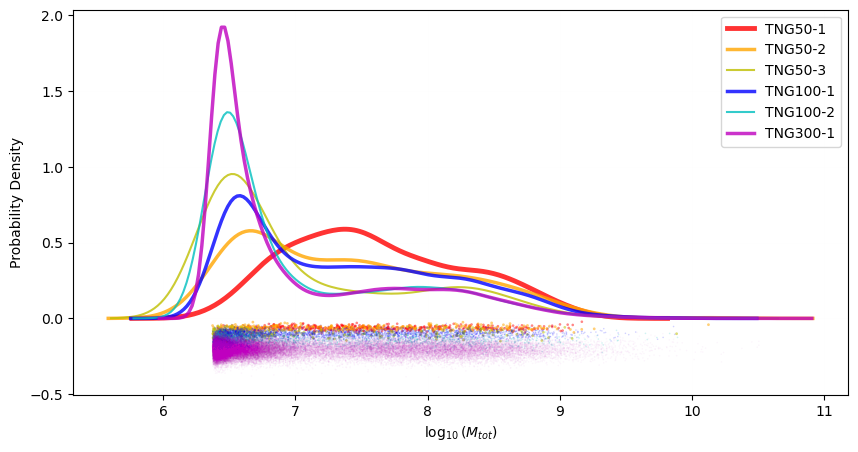

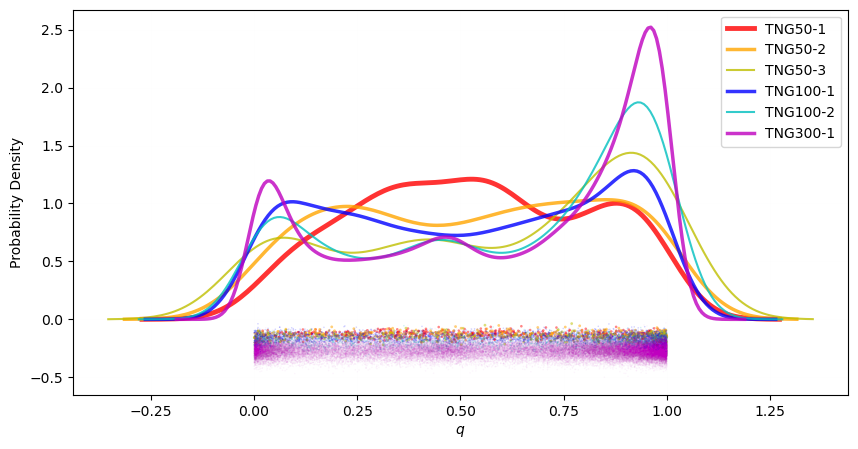

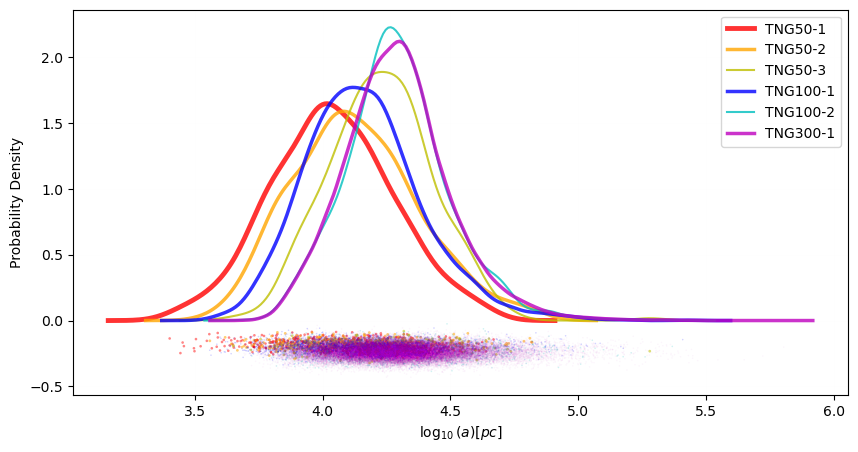

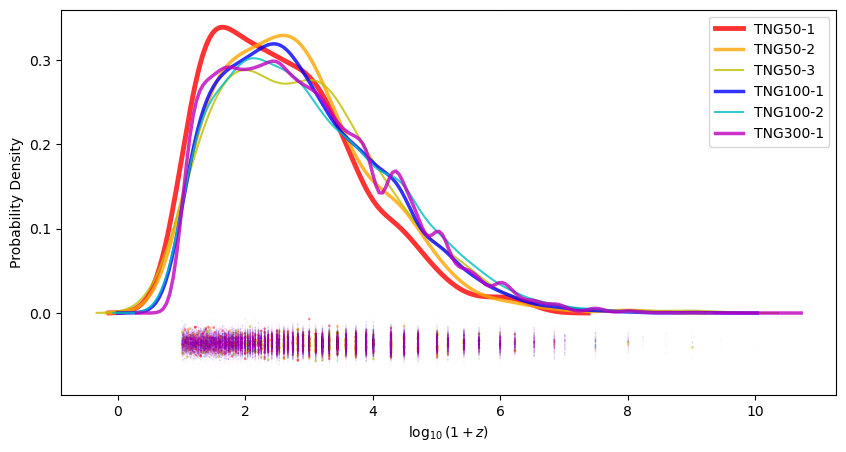

In [13]:
for v in ['mass','mrat','sepa','redz']:
    compare_bin_pops([d.pop for d in tng_dpops], colors=colors, lws=lws,
                     labels=[d.lbl for d in tng_dpops], var=v)
    #compare_bin_pops([d.pop for d in all_sim_dpops], colors=colors, lws=lws,
    #                 labels=[d.lbl for d in all_sim_dpops], var=v)
    plt.legend()
    plt.show()

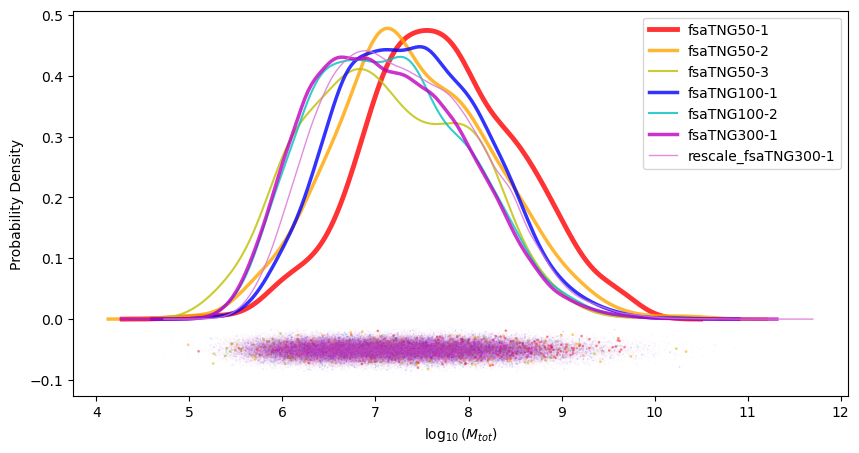

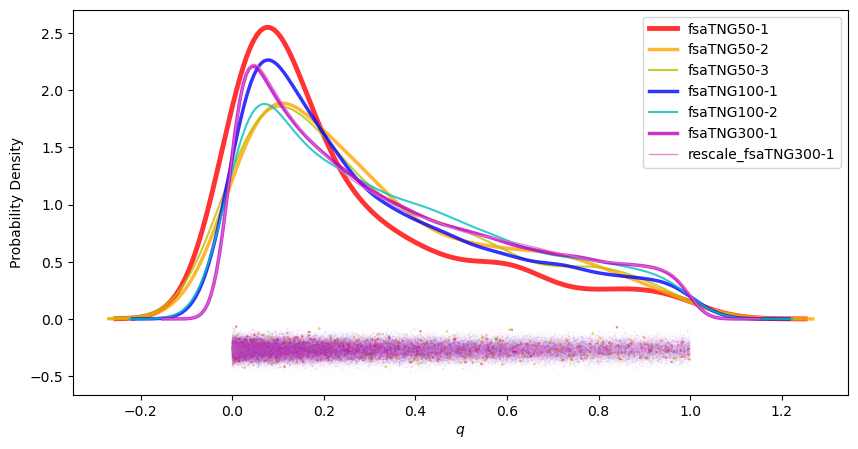

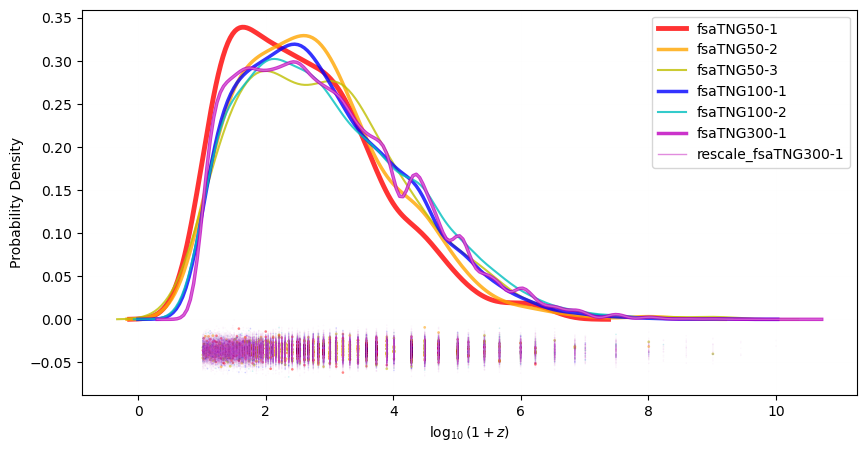

In [14]:
for v in ['mass','mrat','redz']:
    compare_bin_pops([d.pop for d in tng_fsa_dpops], colors=colors, lws=lws,
                     labels=[d.lbl for d in tng_fsa_dpops], var=v)
    #compare_bin_pops([d.pop for d in all_fsa_dpops], colors=colors, lws=lws,
    #                 labels=[d.lbl for d in all_fsa_dpops], var=v)
    plt.legend()
    plt.show()


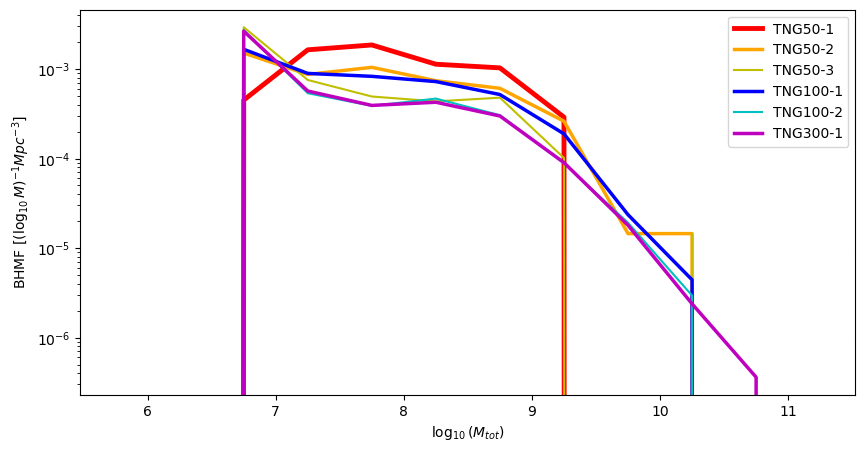

In [15]:
compare_bhmfs([d for d in tng_dpops], colors=colors, lws=lws,
              labels=[d.lbl for d in tng_dpops])
plt.legend()
plt.show()

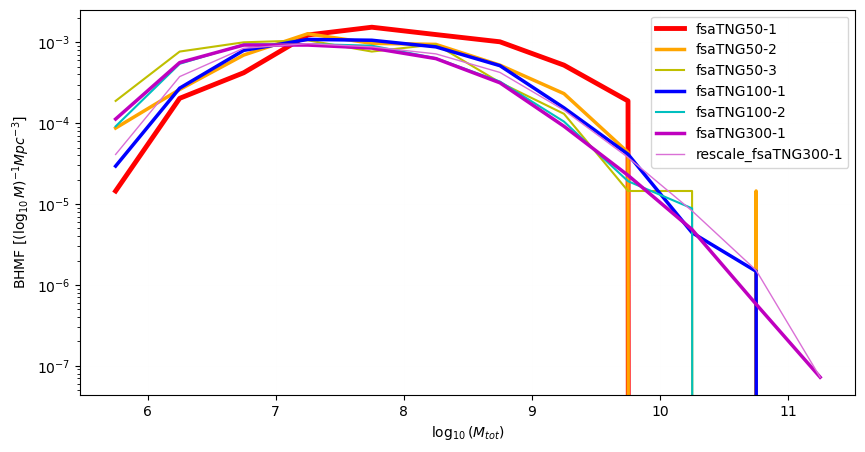

In [16]:
compare_bhmfs([d for d in tng_fsa_dpops], colors=colors, lws=lws,
              labels=[d.lbl for d in tng_fsa_dpops])
plt.legend()
plt.show()

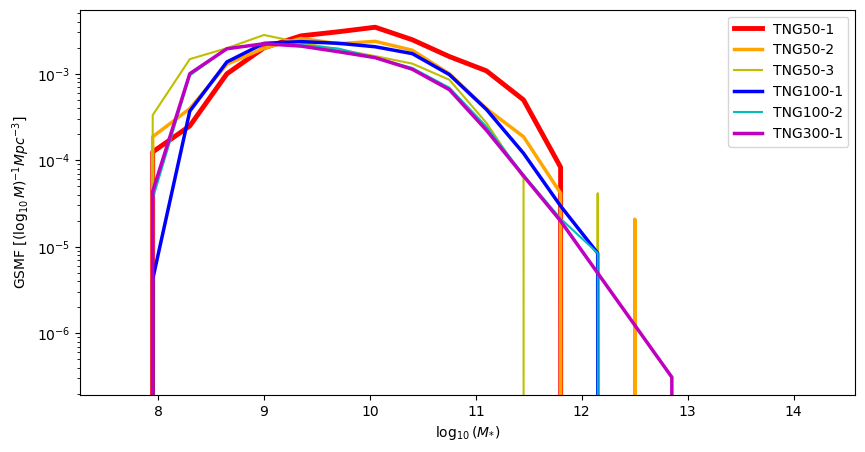

In [34]:
compare_gsmfs([d for d in tng_dpops], colors=colors, lws=lws,
              labels=[d.lbl for d in tng_dpops])
plt.legend()
plt.show()

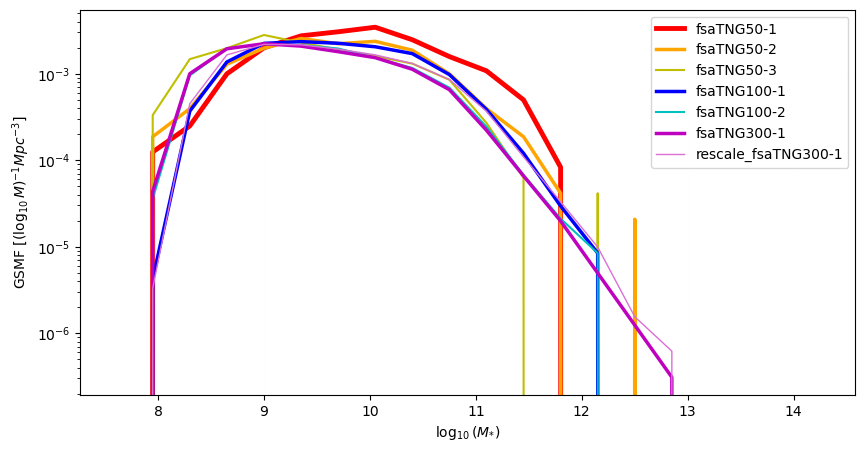

In [35]:
compare_gsmfs([d for d in tng_fsa_dpops], colors=colors, lws=lws,
              labels=[d.lbl for d in tng_fsa_dpops])
plt.legend()
plt.show()

In [ ]:
#rescale_fsa_gwb_tng300_1 = holo.gravwaves.GW_Discrete(rescale_fsa_evo_tng300_1, freqs, nreals=500)
#rescale_fsa_gwb_tng300_1.emit()

### Create SAM for comparison

In [17]:
print("creating sam")
sam = holo.sam.Semi_Analytic_Model()
print("calculating hardening")
hard = holo.hardening.Fixed_Time_2PL_SAM(sam, tau, sepa_init=1.0e4*PC)
print("creating gwb")
#gwb_sam = sam.new_gwb(freqs_edges, hard, realize=500)    # calculate many different realizations
gwb_sam, redz_final_sam, number_sam = sam.new_gwb(freqs_edges, hard, realize=500)

creating sam
calculating hardening
creating gwb
16:33:18 INFO : Stalled SAM bins based on GMT: 2.95e+05/7.44e+05 = 3.96e-01 [sam.py:static_binary_density]
16:33:18 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
16:33:18 INFO : 	dens bef: (0.00e+00, 0.00e+00, 3.14e-61, 8.57e-04, 1.48e-02, 2.79e-02, 4.47e-02) [sam.py:static_binary_density]
16:33:55 INFO : Scatter added after 36.639008 sec [sam.py:static_binary_density]
16:33:55 INFO : 	dens aft: (6.70e-29, 2.54e-15, 3.78e-09, 1.03e-03, 1.50e-02, 2.80e-02, 4.26e-02) [sam.py:static_binary_density]
16:33:55 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.7930e-03 [sam.py:static_binary_density]
16:33:55 INFO : zeroing out 2.95e+05/7.44e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]


In [18]:
print(sam.mtot.shape, sam.mrat.shape, hard._sepa_init, hard._norm.shape)
#sam_dadt_vals = hard.dadt(sam.mtot, sam.mrat, np.repeat(hard._sepa_init,sam.mtot.size))
#print("mtot [msun]:",sam.mtot/MSOL)

(91,) (81,) 3.0856775814913676e+22 (91, 81)


In [19]:
sepa_arr = np.logspace(1.0e-6*PC, hard._sepa_init, 101)
mt, mr, sepa, norm = np.broadcast_arrays(
            sam.mtot[:, np.newaxis, np.newaxis],
            sam.mrat[np.newaxis, :, np.newaxis],
            sepa_arr[np.newaxis, np.newaxis, :],
            hard._norm[:, :, np.newaxis],
        )
print(mt.shape, mr.shape, sepa.shape)
dadt_sam = hard.dadt(mt, mr, sepa, norm)
print(dadt_sam.shape)

(91, 81, 101) (91, 81, 101) (91, 81, 101)
(91, 81, 101)


### Plot amplitudes at 1/yr, 1/3yr, and 1/10yr

In [20]:
for d in all_sim_dpops + all_fsa_dpops:
    d.get_amplitudes_at_freqs()

## this is sketch. only works if freqs is same for all dpops and for sam
ayr_sam = gwb_sam[d.idx_ayr,:].flatten()
a3yr_sam = gwb_sam[d.idx_a3yr,:].flatten()
a10yr_sam = gwb_sam[d.idx_a10yr,:].flatten()


[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]
[32] [20] [7]


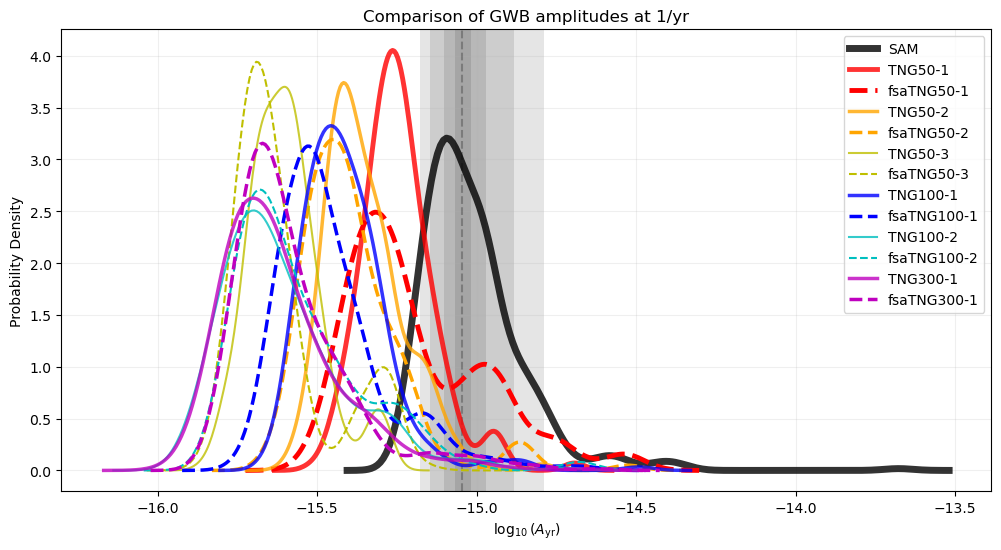

In [21]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(ayr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=5, color='k', label='SAM')
for i in np.arange(len(tng_dpops)):
    kale.dist1d(np.log10(tng_dpops[i].ayr), density=True, hist=False, confidence=False, carpet=False, 
                label=tng_dpops[i].lbl, lw=lws[i], color=colors[i],alpha=0.5)
    kale.dist1d(np.log10(tng_fsa_dpops[i].ayr), density=True, hist=False, confidence=False, carpet=False, 
                label=tng_fsa_dpops[i].lbl, lw=lws[i], color=colors[i],ls='--')

plt.title("Comparison of GWB amplitudes at 1/yr")
plt.legend()
fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A1yr.png')
plt.show()

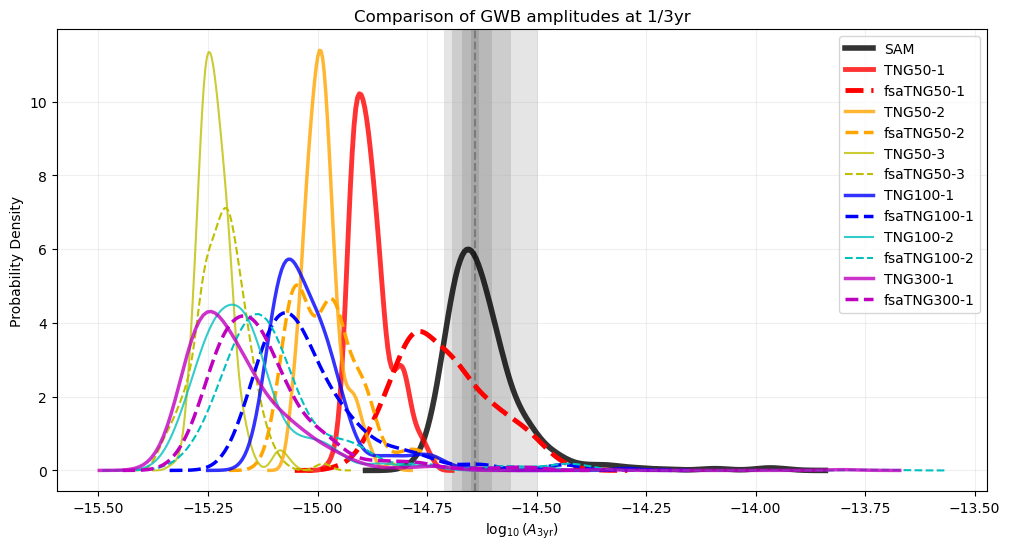

In [22]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{3yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(a3yr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='k', label='SAM')
for i in np.arange(len(tng_dpops)):
    kale.dist1d(np.log10(tng_dpops[i].a3yr), density=True, hist=False, confidence=False, carpet=False, 
                label=tng_dpops[i].lbl, lw=lws[i], color=colors[i],alpha=0.5)
    kale.dist1d(np.log10(tng_fsa_dpops[i].a3yr), density=True, hist=False, confidence=False, carpet=False, 
                label=tng_fsa_dpops[i].lbl, lw=lws[i], color=colors[i],ls='--')

plt.title("Comparison of GWB amplitudes at 1/3yr")
plt.legend()
fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A0.33yr.png')
plt.show()

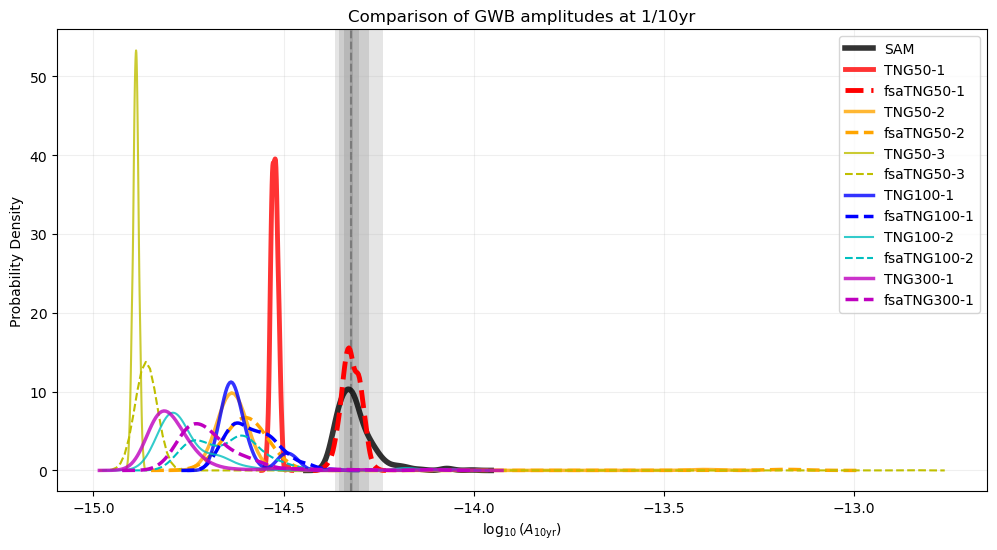

In [23]:
fig, ax = plt.subplots(figsize=[12, 6])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{10yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

kale.dist1d(np.log10(a10yr_sam), density=True, hist=False, confidence=True, carpet=False, 
            lw=4, color='k', label='SAM')
for i in np.arange(len(tng_dpops)):    
    kale.dist1d(np.log10(tng_dpops[i].a10yr), density=True, hist=False, confidence=False,  carpet=False, 
                label=tng_dpops[i].lbl, lw=lws[i], color=colors[i],alpha=0.5)
    kale.dist1d(np.log10(tng_fsa_dpops[i].a10yr), density=True, hist=False, confidence=False,  carpet=False, 
                label=tng_fsa_dpops[i].lbl, lw=lws[i], color=colors[i], ls='--')
    
#kale.dist1d(np.log10(a10yr_fsa_new_ill), density=True, confidence=False, label='a10yr_fsa_new_ill',color='m')
#kale.dist1d(np.log10(a10yr_sam), density=True, confidence=True, label='a10yr_sam')
plt.title("Comparison of GWB amplitudes at 1/10yr")
plt.legend()
fig.savefig(f'compare_dpops_tau{tau/(1e9*YR):.1f}_A0.1yr.png')
plt.show()

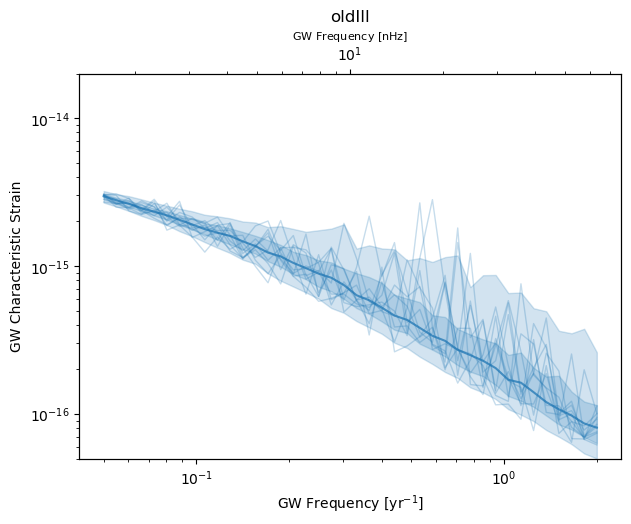

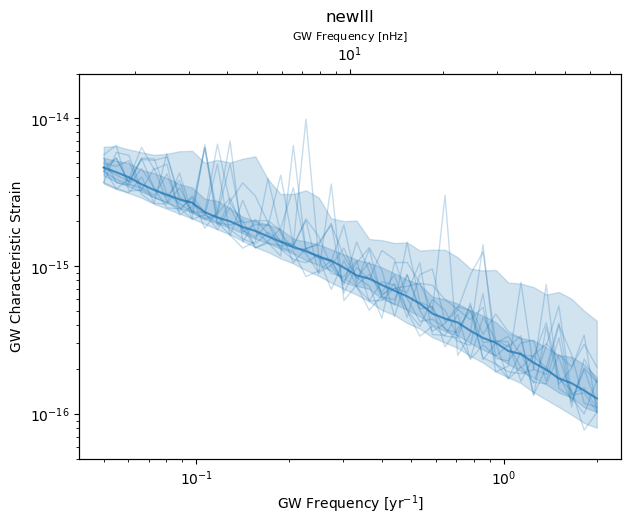

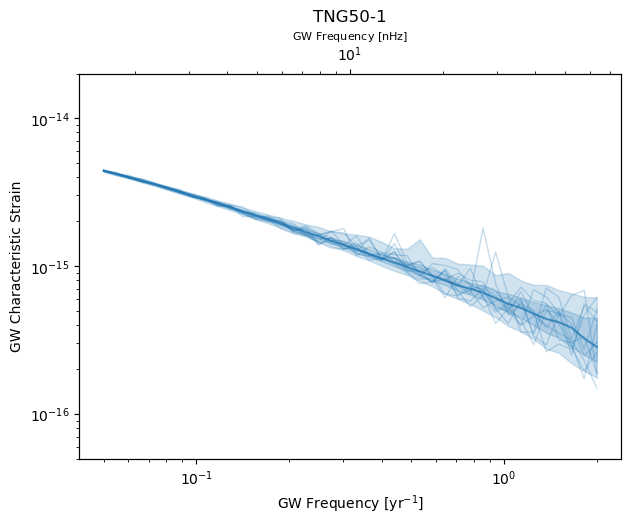

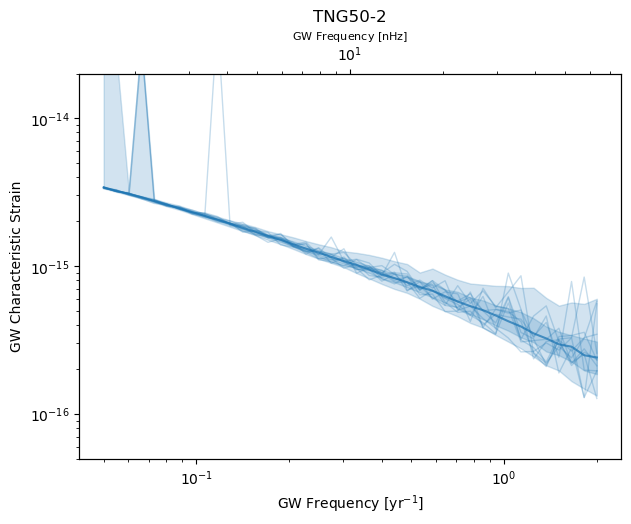

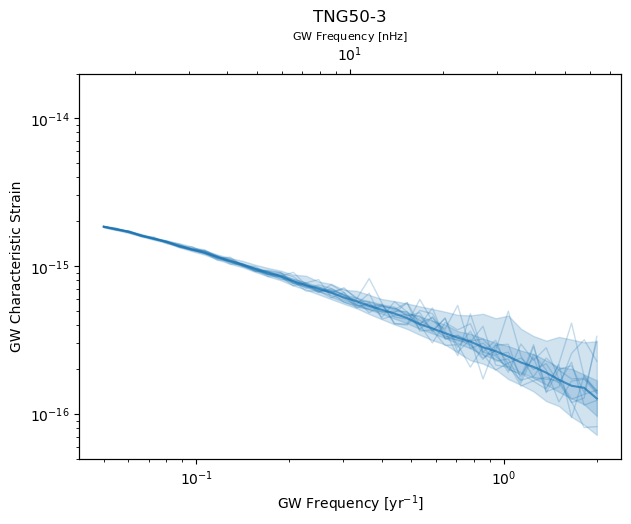

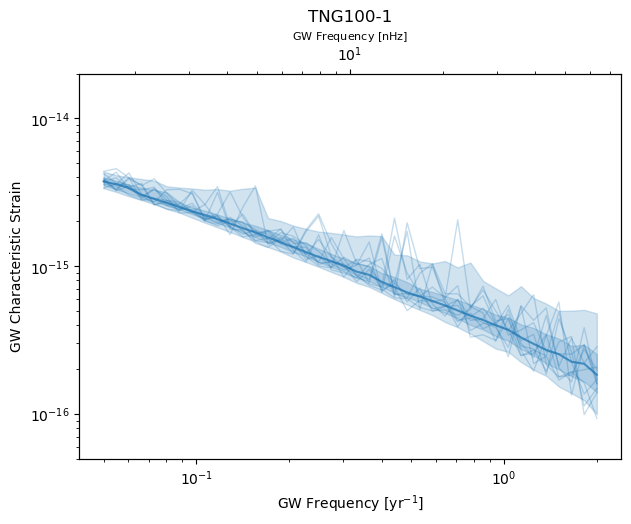

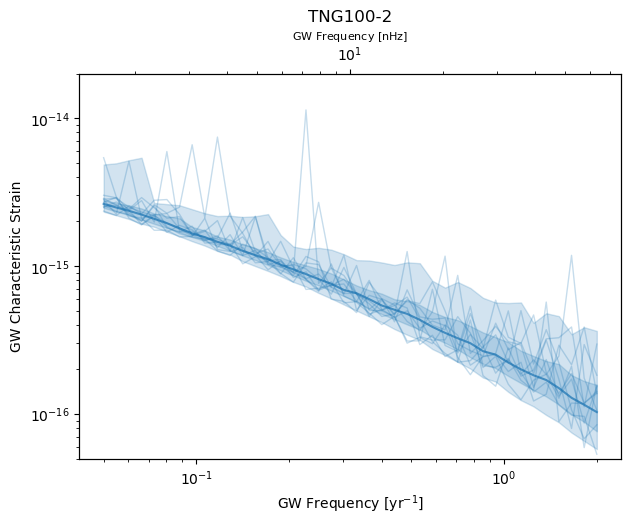

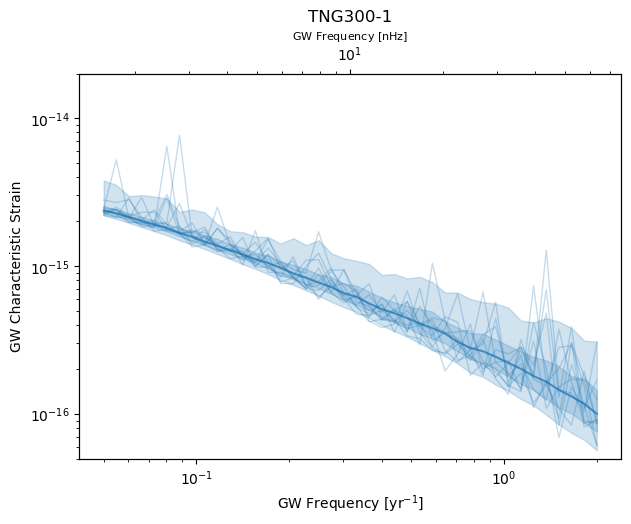

In [24]:
#print(gwb_old_ill.back.shape, gwb_old_ill.fore.shape, gwb_old_ill.loudest.shape)
##plot.plot_gwb(freqs, gwb_new_ill_nst.back)
#print(freqs)
#print(gwb_old_ill.back)
for d in all_sim_dpops:
    plot.plot_gwb(d.freqs, d.gwb.back, ylim=(5.0e-17,2.0e-14))
    plt.title(d.lbl)
#plot.plot_gwb(freqs, gwb_tng50_3.back, ylim=(5.0e-17,2.0e-14))
##plot.plot_gwb(freqs, gwb_sam, ylim=(5.0e-17,2.0e-14))

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


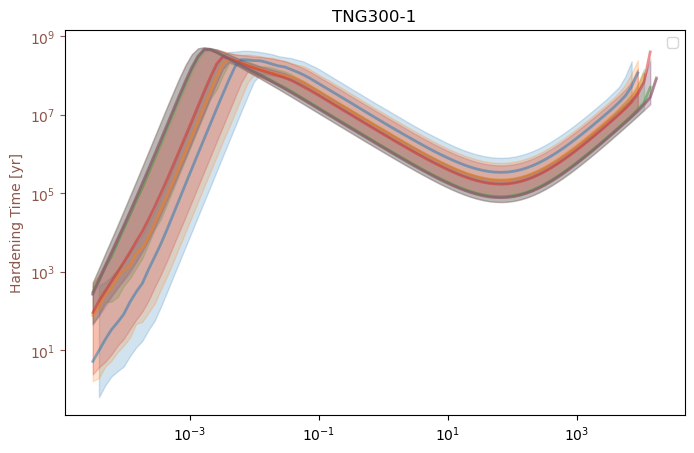

In [25]:
sepa = np.logspace(-4.5, 5, 100) * PC
fig, ax = plot.figax(figsize=(8,5))
for d in tng_dpops:
    plot_evo(d.evo, freqs=None, sepa=sepa, ax=ax)
    plt.title(d.lbl)
    #plot_evo(evo_tng50_3, freqs=None, sepa=sepa, ax=ax)
plt.legend()
plt.show()

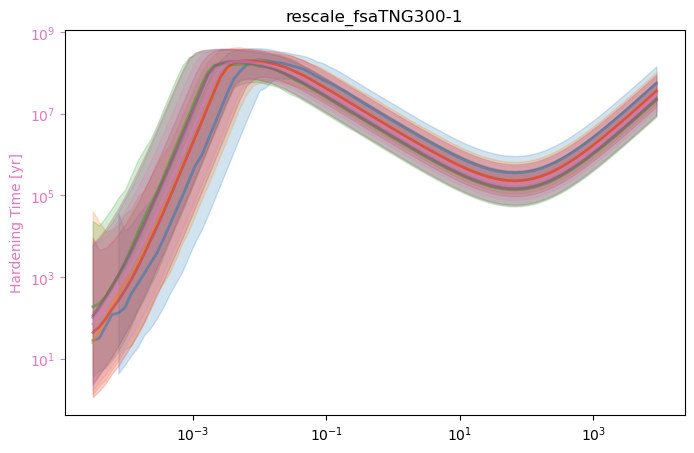

In [26]:
sepa = np.logspace(-4.5, 5, 100) * PC
fig, ax = plot.figax(figsize=(8,5))
for d in tng_fsa_dpops:
    plot_evo(d.evo, freqs=None, sepa=sepa, ax=ax)
    plt.title(d.lbl)
#plt.legend()
plt.show()

NameError: name 'evo_tng100_1' is not defined

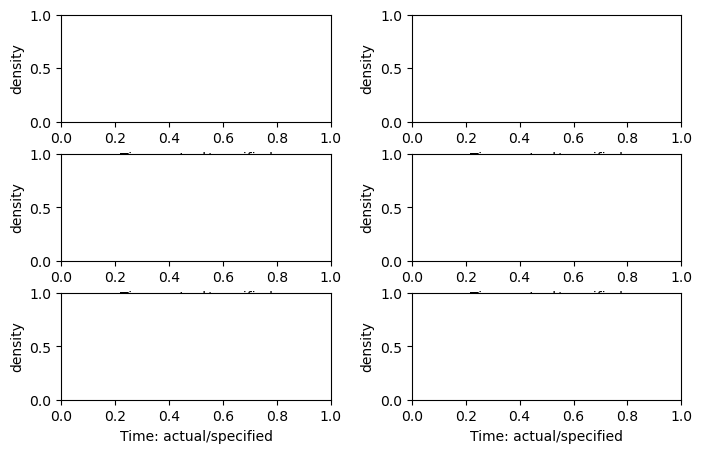

In [28]:
# Calculate the total lifetime of each binary
ncols = 2
nrows = 3
fig, axes = plot.figax(scale='lin', xlabel='Time: actual/specified', ylabel='density',figsize=(8,5),
                       ncols=ncols, nrows=nrows, wspace=0.3,hspace=0.3)
#times = [evo_old_ill.tlook, evo_new_ill.tlook, evo_tng100_1.tlook, evo_tng300_1.tlook, hard.tlook]
times = [evo_tng100_1.tlook, evo_tng300_1.tlook, hard.tlook]

i = 0
for idx,ax in np.ndenumerate(axes):
    i = idx[0]*ncols + idx[1]
    print(f"idx: {idx}, i: {i}")
    dt = times[i][:, 0] - times[i][:, -1]
    # Create figure
    # use kalepy to plot distribution
    kale.dist1d(dt/tau, density=True, ax=ax, label=sim_names[i])
    ax.legend()
    
plt.show()

In [ ]:
for d in tng_pops:
    plot_bin_pop(d)
plt.show()

In [ ]:
#plot_mbh_scaling_relations(fsa_pop_old_ill)
#plot_mbh_scaling_relations(pop_new_ill)
#plot_mbh_scaling_relations(pop_tng100_1)
#plot_mbh_scaling_relations(pop_tng300_1)
#plot_mbh_scaling_relations(pop_old_ill,compare_pops=[pop_new_ill,pop_tng100_1,pop_tng300_1], ncols=2, nrows=2)
plot_mbh_scaling_relations(dpop_new_ill.pop, compare_pops=[d.pop for d in tng_fsa_dpops], 
                           ncols=4, nrows=2,
                           xlim=(6.5,13.2), ylim=(4.5,11.1))
plt.savefig('mmbulge_relations.png')
plt.show()

In [ ]:
print(MSOL)

In [ ]:
print(PC, YR)

In [ ]:
# ---- Old Illustris file, N=100
# Create initial population & fixed-sep population for old illustris file
#pop_old_ill = holo.population.Pop_Illustris()
#fsa_pop_old_ill = holo.population.Pop_Illustris(fixed_sepa=fixed_sepa)

# ---- New Illustris file, N=100
# Create initial population & fixed-sep population for new illustris file
#pop_new_ill = holo.population.Pop_Illustris(fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')
#fsa_pop_new_ill = holo.population.Pop_Illustris(fname='galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5',
#                                                fixed_sepa=fixed_sepa)

# ---- TNG100-1 file, N=100
#Create initial population & fixed-sep population for new illustris file
#pop_tng100_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5')
#fsa_pop_tng100_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG100-1_gas-100_dm-100_star-100_bh-001.hdf5',
#                                                 fixed_sepa=fixed_sepa)

# ---- TNG300-1 file, N=12
# Create initial population & fixed-sep population for new illustris file
#pop_tng300_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5')
#fsa_pop_tng300_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG300-1_gas-012_dm-012_star-012_bh-001.hdf5',
#                                                 fixed_sepa=fixed_sepa)

# ---- TNG50-1 file, N=800
#pop_tng50_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5')
#fsa_pop_tng50_1 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-1_gas-800_dm-800_star-800_bh-001.hdf5',
#                                                fixed_sepa=fixed_sepa)

# ---- TNG50-2 file, N=100 (TNG50-2 res same as TNG100-1)
#pop_tng50_2 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5')
#fsa_pop_tng50_2 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-2_gas-100_dm-100_star-100_bh-001.hdf5',
#                                                fixed_sepa=fixed_sepa)

# ---- TNG50-3 file, N=12 (TNG50-3 res same as TNG300-1)
#pop_tng50_3 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5')
#fsa_pop_tng50_3 = holo.population.Pop_Illustris(fname='galaxy-mergers_TNG50-3_gas-012_dm-012_star-012_bh-001.hdf5',
#                                                fixed_sepa=fixed_sepa)


In [ ]:
#mmbulge = holo.relations.MMBulge_KH2013()
#mod_KH2013 = holo.population.PM_Mass_Reset(mmbulge, scatter=True)
#fsa_pop_old_ill.modify(mod_KH2013)
#fsa_pop_new_ill.modify(mod_KH2013)
#fsa_pop_tng100_1.modify(mod_KH2013)
#fsa_pop_tng300_1.modify(mod_KH2013)
#fsa_pop_tng50_1.modify(mod_KH2013)
#fsa_pop_tng50_2.modify(mod_KH2013)
#fsa_pop_tng50_3.modify(mod_KH2013)


In [ ]:
## create a fixed-total-time hardening mechanism
#fsa_fixed_old_ill = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_old_ill, tau)
## Create an evolution instance using population and hardening mechanism, and evolve it
#fsa_evo_old_ill = holo.evolution.Evolution(fsa_pop_old_ill, fsa_fixed_old_ill)
#fsa_evo_old_ill.evolve()
#print("vol:",fsa_evo_old_ill._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_new_ill = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_new_ill, tau)
## Create an evolution instance using population and hardening mechanism, and evolve it
#fsa_evo_new_ill = holo.evolution.Evolution(fsa_pop_new_ill, fsa_fixed_new_ill)
#fsa_evo_new_ill.evolve()
#print("vol:",fsa_evo_new_ill._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng100_1 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng100_1, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng100_1 = holo.evolution.Evolution(fsa_pop_tng100_1, fsa_fixed_tng100_1)
## evolve binary population
#fsa_evo_tng100_1.evolve()
#print("vol:",fsa_evo_tng100_1._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng300_1 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng300_1, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng300_1 = holo.evolution.Evolution(fsa_pop_tng300_1, fsa_fixed_tng300_1)
## evolve binary population
#fsa_evo_tng300_1.evolve()
#print("vol:",fsa_evo_tng300_1._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng50_1 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng50_1, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng50_1 = holo.evolution.Evolution(fsa_pop_tng50_1, fsa_fixed_tng50_1)
## evolve binary population
#fsa_evo_tng50_1.evolve()
#print("vol:",fsa_evo_tng50_1._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng50_2 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng50_2, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng50_2 = holo.evolution.Evolution(fsa_pop_tng50_2, fsa_fixed_tng50_2)
## evolve binary population
#fsa_evo_tng50_2.evolve()
#print("vol:",fsa_evo_tng50_2._sample_volume)

## create a fixed-total-time hardening mechanism
#fsa_fixed_tng50_3 = holo.hardening.Fixed_Time_2PL.from_pop(fsa_pop_tng50_3, tau)
## Create an evolution instance using population and hardening mechanism
#fsa_evo_tng50_3 = holo.evolution.Evolution(fsa_pop_tng50_3, fsa_fixed_tng50_3)
## evolve binary population
#fsa_evo_tng50_3.evolve()
#print("vol:",fsa_evo_tng50_3._sample_volume)


In [ ]:
# ---- Evolve binary populations

# ---- Old Illustris file

# create a fixed-total-time hardening mechanism
#fixed_old_ill = holo.hardening.Fixed_Time_2PL.from_pop(pop_old_ill, tau)
# Create an evolution instance using population and hardening mechanism, and evolve it
#evo_old_ill = holo.evolution.Evolution(pop_old_ill, fixed_old_ill)
#evo_old_ill.evolve()
#print("vol:",evo_old_ill._sample_volume)


## ---- New illustris file (no subtrees - like old file)

## Create initial population for new illustris file (no subtrees - like old file)
##pop_new_ill_nst = holo.population.Pop_Illustris(fname='nosubtrees-galaxy-mergers_Illustris-1_gas-100_dm-100_star-100_bh-001.hdf5')

# Evolve new illustris (no subtrees) binary population
# create a fixed-total-time hardening mechanism
#fixed_new_ill_nst = holo.hardening.Fixed_Time_2PL.from_pop(pop_new_ill_nst, tau)
# Create an evolution instance using population and hardening mechanism
#evo_new_ill_nst = holo.evolution.Evolution(pop_new_ill_nst, fixed_new_ill_nst)
# evolve binary population
#evo_new_ill_nst.evolve()

# ---- New Illustris file

# create a fixed-total-time hardening mechanism
#fixed_new_ill = holo.hardening.Fixed_Time_2PL.from_pop(pop_new_ill, tau)
# Create an evolution instance using population and hardening mechanism, and evolve it
#evo_new_ill = holo.evolution.Evolution(pop_new_ill, fixed_new_ill)
#evo_new_ill.evolve()
#print("vol:",evo_new_ill._sample_volume)


# ---- TNG100-1 file

# create a fixed-total-time hardening mechanism
#fixed_tng100_1 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng100_1, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng100_1 = holo.evolution.Evolution(pop_tng100_1, fixed_tng100_1)
# evolve binary population
#evo_tng100_1.evolve()
#print("vol:",evo_tng100_1._sample_volume)


# ---- TNG300-1 file

# create a fixed-total-time hardening mechanism
#fixed_tng300_1 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng300_1, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng300_1 = holo.evolution.Evolution(pop_tng300_1, fixed_tng300_1)
# evolve binary population
#evo_tng300_1.evolve()
#print("vol:",evo_tng300_1._sample_volume)

# ---- TNG50-1 file

# create a fixed-total-time hardening mechanism
#fixed_tng50_1 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng50_1, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng50_1 = holo.evolution.Evolution(pop_tng50_1, fixed_tng50_1)
# evolve binary population
#evo_tng50_1.evolve()
#print("vol:",evo_tng50_1._sample_volume)

# ---- TNG50-2 file

# create a fixed-total-time hardening mechanism
#fixed_tng50_2 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng50_2, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng50_2 = holo.evolution.Evolution(pop_tng50_2, fixed_tng50_2)
# evolve binary population
#evo_tng50_2.evolve()
#print("vol:",evo_tng50_2._sample_volume)

# ---- TNG50-1 file

# create a fixed-total-time hardening mechanism
#fixed_tng50_3 = holo.hardening.Fixed_Time_2PL.from_pop(pop_tng50_3, tau)
# Create an evolution instance using population and hardening mechanism
#evo_tng50_3 = holo.evolution.Evolution(pop_tng50_3, fixed_tng50_3)
# evolve binary population
#evo_tng50_3.evolve()
#print("vol:",evo_tng50_3._sample_volume)



In [ ]:
# ---- Create GWB for each discrete population

# old illustris file
#gwb_old_ill = holo.gravwaves.GW_Discrete(evo_old_ill, freqs, nreals=500)
#gwb_old_ill.emit()

# new illustris file (no subtrees - like old file)
##gwb_new_ill_nst = holo.gravwaves.GW_Discrete(evo_new_ill_nst, freqs, nreals=1000)
##gwb_new_ill_nst.emit()

## new illustris file
#gwb_new_ill = holo.gravwaves.GW_Discrete(evo_new_ill, freqs, nreals=500)
#gwb_new_ill.emit()

## TNG100-1 file
#gwb_tng100_1 = holo.gravwaves.GW_Discrete(evo_tng100_1, freqs, nreals=500)
#gwb_tng100_1.emit()

## TNG300-1 file
#gwb_tng300_1 = holo.gravwaves.GW_Discrete(evo_tng300_1, freqs, nreals=500)
#gwb_tng300_1.emit()

## TNG50-1 file
#gwb_tng50_1 = holo.gravwaves.GW_Discrete(evo_tng50_1, freqs, nreals=500)
#gwb_tng50_1.emit()

## TNG50-2 file
#gwb_tng50_2 = holo.gravwaves.GW_Discrete(evo_tng50_2, freqs, nreals=500)
#gwb_tng50_2.emit()

## TNG50-3 file
#gwb_tng50_3 = holo.gravwaves.GW_Discrete(evo_tng50_3, freqs, nreals=500)
#gwb_tng50_3.emit()


In [ ]:
#fsa_gwb_old_ill = holo.gravwaves.GW_Discrete(fsa_evo_old_ill, freqs, nreals=500)
#fsa_gwb_old_ill.emit()

#fsa_gwb_new_ill = holo.gravwaves.GW_Discrete(fsa_evo_new_ill, freqs, nreals=500)
#fsa_gwb_new_ill.emit()

#fsa_gwb_tng100_1 = holo.gravwaves.GW_Discrete(fsa_evo_tng100_1, freqs, nreals=500)
#fsa_gwb_tng100_1.emit()

#fsa_gwb_tng300_1 = holo.gravwaves.GW_Discrete(fsa_evo_tng300_1, freqs, nreals=500)
#fsa_gwb_tng300_1.emit()

#fsa_gwb_tng50_1 = holo.gravwaves.GW_Discrete(fsa_evo_tng50_1, freqs, nreals=500)
#fsa_gwb_tng50_1.emit()

#fsa_gwb_tng50_2 = holo.gravwaves.GW_Discrete(fsa_evo_tng50_2, freqs, nreals=500)
#fsa_gwb_tng50_2.emit()

#fsa_gwb_tng50_3 = holo.gravwaves.GW_Discrete(fsa_evo_tng50_3, freqs, nreals=500)
#fsa_gwb_tng50_3.emit()

In [ ]:

# ---- amplitudes at ~ 1 / yr
#ayr_old_ill = gwb_old_ill.back[idx_ayr,:].flatten()
#ayr_new_ill = gwb_new_ill.back[idx_ayr,:].flatten()
#ayr_tng100_1 = gwb_tng100_1.back[idx_ayr,:].flatten()
#ayr_tng300_1 = gwb_tng300_1.back[idx_ayr,:].flatten()
#ayr_tng50_1 = gwb_tng50_1.back[idx_ayr,:].flatten()
#ayr_tng50_2 = gwb_tng50_2.back[idx_ayr,:].flatten()
#ayr_tng50_3 = gwb_tng50_3.back[idx_ayr,:].flatten()
#ayr_mod_tng300_1 = mod_gwb_tng300_1.back[idx_ayr,:].flatten()
#ayr_sam = gwb_sam[idx_ayr,:].flatten()

#ayr_fsa_old_ill = fsa_gwb_old_ill.back[idx_ayr,:].flatten()
#ayr_fsa_new_ill = fsa_gwb_new_ill.back[idx_ayr,:].flatten()
#ayr_fsa_tng100_1 = fsa_gwb_tng100_1.back[idx_ayr,:].flatten()
#ayr_fsa_tng300_1 = fsa_gwb_tng300_1.back[idx_ayr,:].flatten()
#ayr_fsa_tng50_1 = fsa_gwb_tng50_1.back[idx_ayr,:].flatten()
#ayr_fsa_tng50_2 = fsa_gwb_tng50_2.back[idx_ayr,:].flatten()
#ayr_fsa_tng50_3 = fsa_gwb_tng50_3.back[idx_ayr,:].flatten()
#ayr_rescale_fsa_tng300_1 = rescale_fsa_gwb_tng300_1.back[idx_ayr,:].flatten()

# ---- amplitudes at ~ 1 / 3yr
#a3yr_old_ill = gwb_old_ill.back[idx_a3yr,:].flatten()
#a3yr_new_ill = gwb_new_ill.back[idx_a3yr,:].flatten()
#a3yr_tng100_1 = gwb_tng100_1.back[idx_a3yr,:].flatten()
#a3yr_tng300_1 = gwb_tng300_1.back[idx_a3yr,:].flatten()
#a3yr_tng50_1 = gwb_tng50_1.back[idx_a3yr,:].flatten()
#a3yr_tng50_2 = gwb_tng50_2.back[idx_a3yr,:].flatten()
#a3yr_tng50_3 = gwb_tng50_3.back[idx_a3yr,:].flatten()
#a3yr_mod_tng300_1 = mod_gwb_tng300_1.back[idx_a3yr,:].flatten()
#a3yr_sam = gwb_sam[idx_a3yr,:].flatten()

#a3yr_fsa_old_ill = fsa_gwb_old_ill.back[idx_a3yr,:].flatten()
#a3yr_fsa_new_ill = fsa_gwb_new_ill.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng100_1 = fsa_gwb_tng100_1.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng300_1 = fsa_gwb_tng300_1.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng50_1 = fsa_gwb_tng50_1.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng50_2 = fsa_gwb_tng50_2.back[idx_a3yr,:].flatten()
#a3yr_fsa_tng50_3 = fsa_gwb_tng50_3.back[idx_a3yr,:].flatten()
#a3yr_rescale_fsa_tng300_1 = rescale_fsa_gwb_tng300_1.back[idx_a3yr,:].flatten()

# ---- amplitudes at ~ 1 / 10yr
#a10yr_old_ill = gwb_old_ill.back[idx_a10yr,:].flatten()
#a10yr_new_ill = gwb_new_ill.back[idx_a10yr,:].flatten()
#a10yr_tng100_1 = gwb_tng100_1.back[idx_a10yr,:].flatten()
#a10yr_tng300_1 = gwb_tng300_1.back[idx_a10yr,:].flatten()
#a10yr_tng50_1 = gwb_tng50_1.back[idx_a10yr,:].flatten()
#a10yr_tng50_2 = gwb_tng50_2.back[idx_a10yr,:].flatten()
#a10yr_tng50_3 = gwb_tng50_3.back[idx_a10yr,:].flatten()
#a10yr_mod_tng300_1 = mod_gwb_tng300_1.back[idx_a10yr,:].flatten()
#a10yr_sam = gwb_sam[idx_a10yr,:].flatten()

#a10yr_fsa_old_ill = fsa_gwb_old_ill.back[idx_a10yr,:].flatten()
#a10yr_fsa_new_ill = fsa_gwb_new_ill.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng100_1 = fsa_gwb_tng100_1.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng300_1 = fsa_gwb_tng300_1.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng50_1 = fsa_gwb_tng50_1.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng50_2 = fsa_gwb_tng50_2.back[idx_a10yr,:].flatten()
#a10yr_fsa_tng50_3 = fsa_gwb_tng50_3.back[idx_a10yr,:].flatten()
#a10yr_rescale_fsa_tng300_1 = rescale_fsa_gwb_tng300_1.back[idx_a10yr,:].flatten()

#print(ayr_old_ill.shape)